In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from extract_data import init_extraction
from split_data import create_train_test_time_series

In [3]:
df_synth, df_hist = init_extraction()
df_hist.head()

,price
date,
2016-12-31 23:00:00+00:00,58.82
2017-01-01 00:00:00+00:00,58.23
2017-01-01 01:00:00+00:00,51.95
2017-01-01 02:00:00+00:00,47.27
2017-01-01 03:00:00+00:00,45.49


In [4]:
df_synth['01865.parquet'].head()

,price
date,
2016-12-31 23:00:00+00:00,31.66
2017-01-01 00:00:00+00:00,31.06
2017-01-01 01:00:00+00:00,27.81
2017-01-01 02:00:00+00:00,27.54
2017-01-01 03:00:00+00:00,25.04


In [5]:
train, test = create_train_test_time_series(df_hist, horizon_hours=168)

print("Train set :\n", train.tail())
print("Test set :\n", test)

Train set :
                            price
date                            
2020-12-24 18:00:00+00:00  45.09
2020-12-24 19:00:00+00:00  36.18
2020-12-24 20:00:00+00:00  33.10
2020-12-24 21:00:00+00:00  33.32
2020-12-24 22:00:00+00:00  29.98
Test set :
                            price
date                            
2020-12-24 23:00:00+00:00  29.90
2020-12-25 00:00:00+00:00  22.61
2020-12-25 01:00:00+00:00  16.00
2020-12-25 02:00:00+00:00  12.57
2020-12-25 03:00:00+00:00   8.00
...                          ...
2020-12-31 18:00:00+00:00  60.54
2020-12-31 19:00:00+00:00  56.75
2020-12-31 20:00:00+00:00  52.44
2020-12-31 21:00:00+00:00  51.86
2020-12-31 22:00:00+00:00  52.26

[168 rows x 1 columns]


In [8]:
def sarima_forecast_multiple_horizons(
        data: pd.DataFrame,
        horizons = [6, 12, 24, 48, 72, 168],
        title=''
):
    """
    - Coupe toujours les 168 dernières heures comme test set.
    - Entraîne un seul modèle ARIMA (seasonal=False, m=1) sur le train.
    - Pour chacun des horizons dans 'horizons', effectue une prédiction de 'h' heures
      et compare avec les 'h' premières heures du test.
    - Affiche un graphique (zoomé) et calcule les métriques (MAE, RMSE).

    Retourne un dict : { horizon: { 'MAE': ..., 'RMSE': ... } }
    """
    # 1) Split : 168h pour le test
    train, test = create_train_test_time_series(data, horizon_hours=168)

    # 2) Entraînement d'un ARIMA sans saisonnalité sur tout le train
    print("=== Entraînement du modèle ARIMA (unique) sur l'ensemble du train ===")
    arima_model = auto_arima(
        train,
        seasonal=False,  # pas de saisonnalité
        m=1,
        trace=True,
        error_action='ignore',
        suppress_warnings=True
    )
    print("\n--- Modèle sélectionné par auto_arima ---")
    print(arima_model.summary())

    arima_model.fit(train)

    # 3) Pour chaque horizon, on fait la prédiction
    results = {}
    for h in horizons:
        # 3a) Prédire h heures
        forecast = arima_model.predict(n_periods=h)

        # L'index de prévision = les h premières heures du test
        forecast_index = test.index[:h]
        forecast_series = pd.Series(forecast, index=forecast_index)

        # 3b) Calcul des métriques
        test_subset = test.iloc[:h]
        mae = mean_absolute_error(test_subset, forecast_series)
        mse = mean_squared_error(test_subset, forecast_series)
        rmse = math.sqrt(mse)
        results[h] = {'MAE': mae, 'MSE':mse, 'RMSE': rmse}

        # 3c) Affichage du graphique
        # Déterminons combien d'heures de train on affiche => 2*h heures
        train_display_length = 2 * h
        train_part = (
            train.iloc[-train_display_length:]
            if train_display_length < len(train)
            else train
        )

        plt.figure(figsize=(10, 5))

        # -- Trace train (bleu) --
        plt.plot(train_part.index, train_part.values, label='Train', color='blue')
        # -- Trace test (orange) --
        plt.plot(test_subset.index, test_subset.values, label='Test', color='orange')
        # -- Relier le dernier point du train au premier du test (même couleur que train)
        if (len(train_part) > 0) and (len(test_subset) > 0):
            last_train_time = train_part.index[-1]
            last_train_value = train_part.values[-1]
            first_test_time = test_subset.index[0]
            first_test_value = test_subset.values[0]
            # On ajoute un petit segment si la date du test est immédiatement après le train
            if last_train_time < first_test_time:
                plt.plot([last_train_time, first_test_time],
                         [last_train_value, first_test_value],
                         color='blue', linestyle='--')

        # -- Trace la prévision (vert) --
        plt.plot(forecast_series.index, forecast_series.values,label=f'Prévision h={h}', color='green')
        # Titre
        plt.title(f"{title}\nHorizon = {h}h - MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}")
        plt.legend()
        # -- Formatage de l'axe X pour afficher "MM/DD\nHHhMM" --
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d\n%Hh%M'))

        plt.show()

    return results

=== Entraînement du modèle ARIMA (unique) sur l'ensemble du train ===
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=16.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=218409.905, Time=0.24 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=214067.935, Time=0.30 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=213949.536, Time=1.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=218407.906, Time=0.12 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=213790.112, Time=1.38 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=209939.197, Time=3.96 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=213610.727, Time=0.49 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=209870.407, Time=7.45 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=213109.130, Time=1.00 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=209836.986, Time=10.31 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=212738.229, Time=1.52 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=209777.130, Time=11.87 sec
 ARIMA(

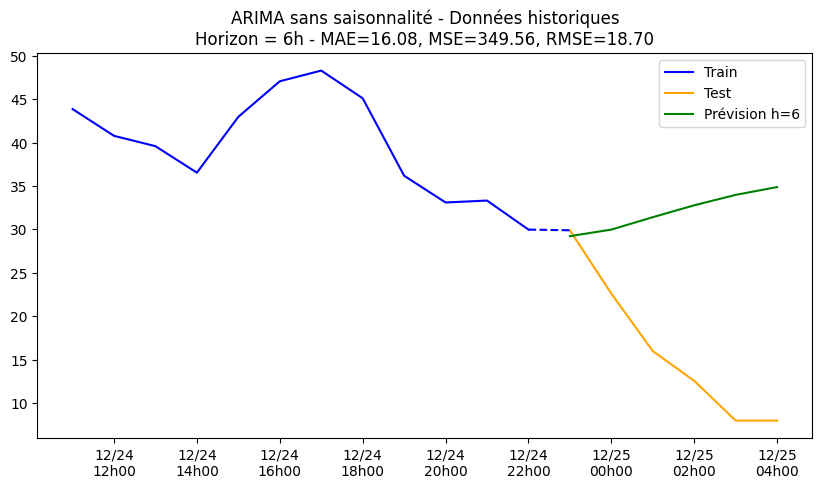

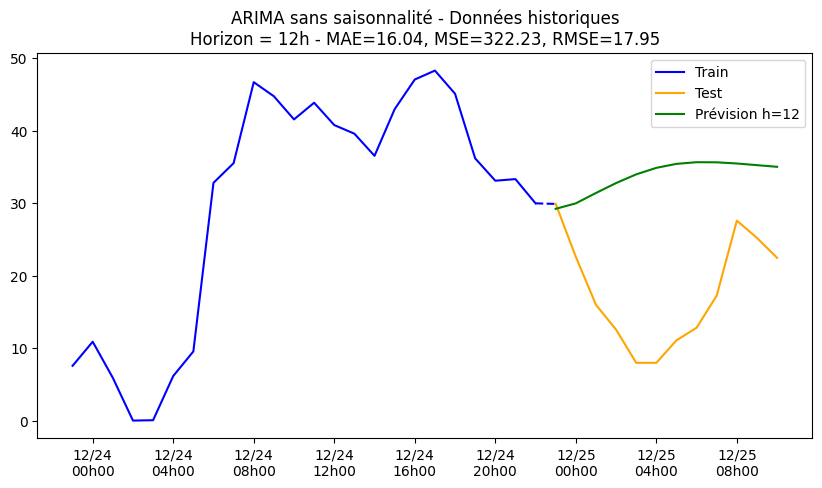

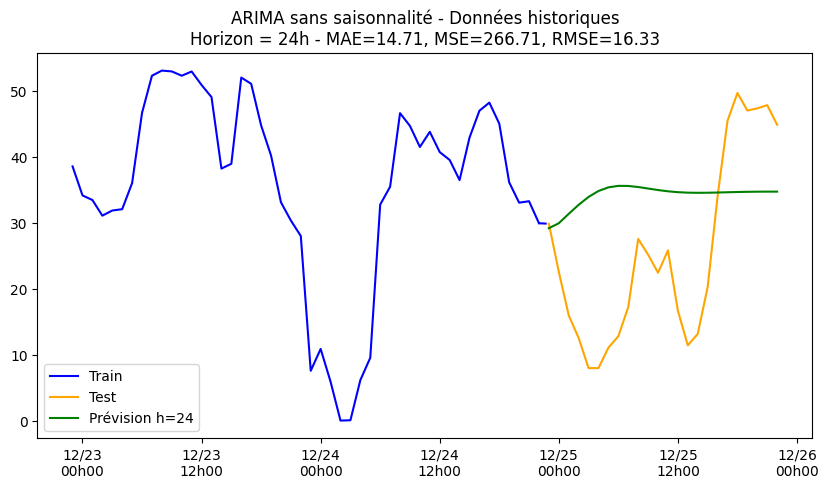

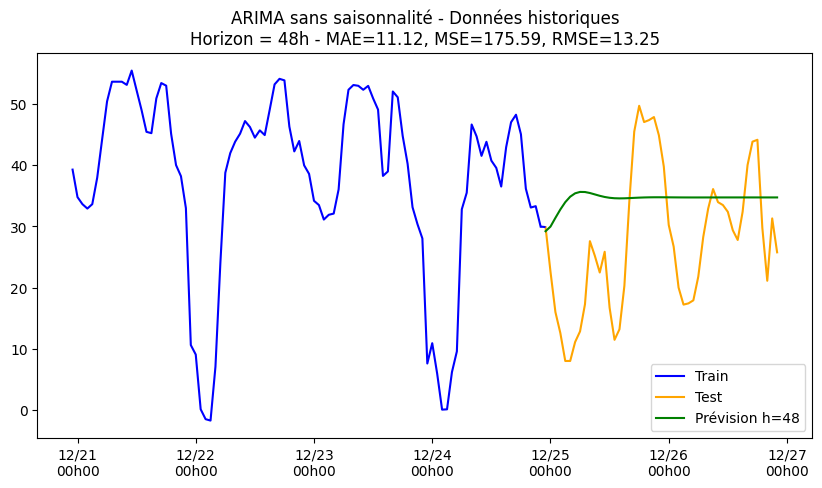

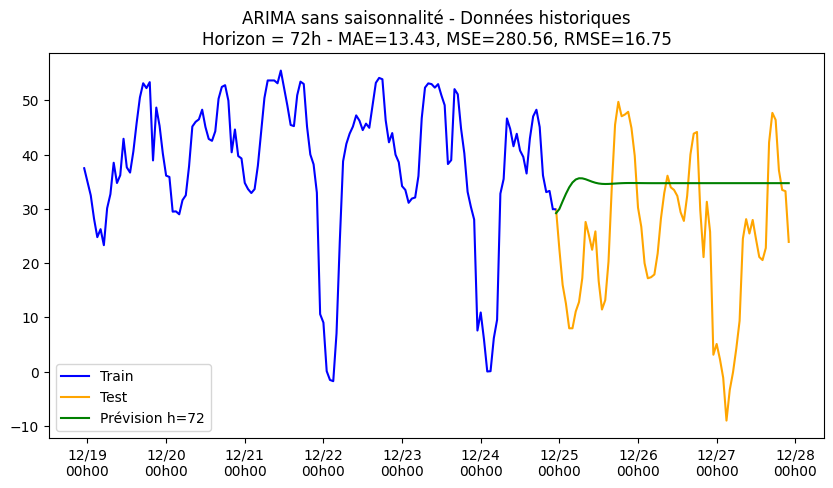

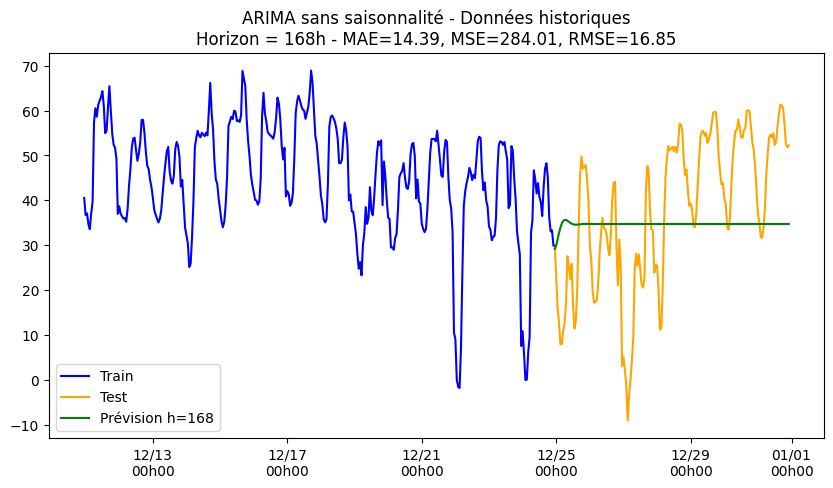

In [9]:
results_no_synth = sarima_forecast_multiple_horizons(
    data=df_hist,
    horizons=[6, 12, 24, 48, 72, 168],
    title="ARIMA sans saisonnalité - Données historiques"
)

In [11]:
print("=== Récapitulatif des métriques ===")
for h, vals in results_no_synth.items():
    print(f"Horizon {h}h => MAE={vals['MAE']:.2f}, MSE={vals['MSE']:.2f}, RMSE={vals['RMSE']:.2f}")

=== Récapitulatif des métriques ===
Horizon 6h => MAE=16.08, MSE=349.56, RMSE=18.70
Horizon 12h => MAE=16.04, MSE=322.23, RMSE=17.95
Horizon 24h => MAE=14.71, MSE=266.71, RMSE=16.33
Horizon 48h => MAE=11.12, MSE=175.59, RMSE=13.25
Horizon 72h => MAE=13.43, MSE=280.56, RMSE=16.75
Horizon 168h => MAE=14.39, MSE=284.01, RMSE=16.85


## Amélioration de la méthode

In [12]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    adf_test = adfuller(timeseries)
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    if adf_test[1] <= 0.05:
        print("Les données sont stationnaires (p-value <= 0.05).")
    else:
        print("Les données ne sont pas stationnaires (p-value > 0.05).")

test_stationarity(train)

ADF Statistic: -9.737101687076402
p-value: 8.691285189383225e-17
Les données sont stationnaires (p-value <= 0.05).


On voit que les données sont stationnaires. Pas besoin de différenciation.
essayons de rajouter la saisonnalité.

In [ ]:
# /!\ Cette cellule peut prendre du temps à s'exécuter
# C'est pour cette raison que la saisonnalité n'avait pas été testée au cours du test précédent
############################
####### Important ##########
############################
# Après 40min d'execution, le code de cette cellule freeze, aucun changement même après 11h d'execution.
# Impossible d'utiliser SARIMA avec la saisonnalité.
arima_model = auto_arima(
    train,
    seasonal=True,
    m=24,  # Par exemple, une saisonnalité journalière (24 heures)
    trace=True,
    error_action='ignore',
    suppress_warnings=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[24] intercept   : AIC=inf, Time=145.88 sec
 ARIMA(0,1,0)(0,0,0)[24] intercept   : AIC=218409.905, Time=0.26 sec
 ARIMA(1,1,0)(1,0,0)[24] intercept   : AIC=202322.381, Time=14.70 sec
 ARIMA(0,1,1)(0,0,1)[24] intercept   : AIC=206631.667, Time=22.77 sec
 ARIMA(0,1,0)(0,0,0)[24]             : AIC=218407.906, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[24] intercept   : AIC=214067.935, Time=0.57 sec
 ARIMA(1,1,0)(2,0,0)[24] intercept   : AIC=200892.964, Time=162.55 sec
 ARIMA(1,1,0)(2,0,1)[24] intercept   : AIC=inf, Time=312.03 sec
 ARIMA(1,1,0)(1,0,1)[24] intercept   : AIC=inf, Time=33.42 sec
 ARIMA(0,1,0)(2,0,0)[24] intercept   : AIC=201194.046, Time=152.84 sec
 ARIMA(2,1,0)(2,0,0)[24] intercept   : AIC=200695.015, Time=208.49 sec
 ARIMA(2,1,0)(1,0,0)[24] intercept   : AIC=202172.431, Time=20.92 sec


In [ ]:
def plot_arima_predictions(arima_model, train, test, horizons, title=""):
    """
    - Effectue des prédictions sur plusieurs horizons donnés.
    - Calcule les métriques (MAE, MSE, RMSE) pour chaque horizon.
    - Affiche un graphique pour chaque horizon (train, test, prévision).
    """
    results = {}

    for h in horizons:
        # 1. Faire une prédiction sur l'horizon h
        forecast = arima_model.predict(n_periods=h)

        # L'index de prévision = les h premières heures du test
        forecast_index = test.index[:h]
        forecast_series = pd.Series(forecast, index=forecast_index)

        # 2. Calculer les métriques
        test_subset = test.iloc[:h]
        mae = mean_absolute_error(test_subset, forecast_series)
        mse = mean_squared_error(test_subset, forecast_series)
        rmse = math.sqrt(mse)

        results[h] = {"MAE": mae, "MSE": mse, "RMSE": rmse}

        # 3. Préparer les données pour l'affichage
        train_display_length = 2 * h
        train_part = (
            train.iloc[-train_display_length:]
            if train_display_length < len(train)
            else train
        )

        # 4. Afficher le graphique
        plt.figure(figsize=(10, 5))

        # Tracer le train (bleu)
        plt.plot(train_part.index, train_part.values, label="Train", color="blue")

        # Tracer le test (orange)
        plt.plot(test_subset.index, test_subset.values, label="Test", color="orange")

        # Ajouter un segment entre train et test si nécessaire
        if (len(train_part) > 0) and (len(test_subset) > 0):
            last_train_time = train_part.index[-1]
            last_train_value = train_part.values[-1]
            first_test_time = test_subset.index[0]
            first_test_value = test_subset.values[0]
            if last_train_time < first_test_time:
                plt.plot(
                    [last_train_time, first_test_time],
                    [last_train_value, first_test_value],
                    color="blue",
                    linestyle="--",
                )

        # Tracer la prévision (vert)
        plt.plot(
            forecast_series.index,
            forecast_series.values,
            label=f"Prévision h={h}",
            color="green",
        )

        # Titre et légendes
        plt.title(f"{title}\nHorizon = {h}h - MAE={mae:.2f}, MSE={mse:.2f}, RMSE={rmse:.2f}")
        plt.legend()

        # Formatage de l'axe X pour afficher "MM/DD\nHHhMM"
        ax = plt.gca()
        ax.xaxis.set_major_formatter(mdates.DateFormatter("%m/%d\n%Hh%M"))

        plt.show()

    return results


In [ ]:
results = plot_arima_predictions(
    arima_model=arima_model,
    train=train,
    test=test,
    horizons=[6, 12, 24, 48, 72, 168],
    title="Prédictions ARIMA sur plusieurs horizons"
)

# Afficher les métriques pour chaque horizon
print(pd.DataFrame(results).T)